In [244]:
# Carregando as bibliotecas

import pandas as pd
import numpy as np

import yfinance
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import kaleido

import random

import warnings

warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()

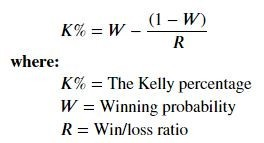

- Nesta fórmula acima, K% é a porcentagem de Kelly, W é a probabilidade de vitória e R é a proporção de vitórias/perdas. O cálculo é realmente muito simples.

1. Colete seus últimos 40 a 50 trades.


2. Calcule “W”, a probabilidade de ganhar. Você pode simplesmente dividir o número de negociações vencedoras pelo número total de negociações. Esse número é melhor se estiver mais próximo de um, embora qualquer número acima de 0,50 seja bom.

 - Por exemplo, nos meus últimos 50 trades, tenho 30 trades vencedores e, portanto,sei que minha probabilidade de ganho aproximado é de 0,60 (30/50 = 0,60)


3. Calcule “R”, a proporção de vitórias/perdas. Isso fica um pouco complicado, você precisa dividir o ganho médio das negociações vencedoras pela perda média dos trades perdedores. Você deve ter um número maior que 1 se sua média de ganhos for maior que sua média de perdas.

 - Por exemplo, nos meus últimos 50 trades, meu lucro total das 30 negociações vencedoras é de 3000 reais, portanto, sei que meu ganho médio é de 100 (3000 / 30). Além disso, a perda total dos 20 trades perdedores é de 1500 reais, o que eu tenho uma perda média de 75 (1500/20). Agora podemos dividir o ganho médio de 100 pela perda média de 75, o que nos dá uma relação ganho/perda de 1,33.


4. Coloque o W e R que calculamos na equação de Kelly

In [245]:
# Conjunto de funções para aplicar o critério kelly

def get_kelly(W, R):
    kelly = W - (1-W)/R
    return kelly


def get_cumulative_returns(returns):
    cum_returns = (returns).cumsum()
    cum_returns = cum_returns.dropna()
    
    return cum_returns

In [246]:
#tickers = ["PETR4.SA", "VALE", "ITUB4.SA"
#           , "CMIG4.SA", "USIM5.SA", "CSNA3.SA"]

tickers = "PETR4.SA"

start = "2020-01-02"
end = "2022-12-31"

df0 = yfinance.download(tickers, start, end)

[*********************100%***********************]  1 of 1 completed


In [247]:
df0["Retornos"] = df0["Adj Close"].pct_change()
#df0["Dir"] = np.where(df0["Retornos"] > 0, 1, 0)
#df0["W"] = df0["Dir"].rolling(10).mean()
df0["W"] = np.random.randint(1000, size = df0.shape[0])/1000
df0["R"] = np.random.randint(1000, size = df0.shape[0])/1000+1
df0["Alvo"] = df0["Retornos"].shift(-1)


df0 = df0.dropna(axis = 0) 

f_kelly = get_kelly(df0["W"], df0["R"])


df_kelly = pd.DataFrame()
df_kelly["Kelly"] = f_kelly

# Filtra o kelly negativo
df_kelly["Kelly"] = np.where(df_kelly["Kelly"] < 0, 0, df_kelly["Kelly"])

In [248]:
df_kelly

,Kelly
Date,
2020-01-03,0.000000
2020-01-06,0.256613
2020-01-07,0.331984
2020-01-08,0.000000
2020-01-09,0.974419
...,...
2022-12-19,0.695378
2022-12-20,0.000000
2022-12-21,0.000000


In [249]:
#Visualiza o K de Kelly

fig = make_subplots(rows = 1, cols = 1,
                    shared_xaxes = True,
                    vertical_spacing = 0.08)

fig.add_trace(go.Scatter(x = df_kelly.index
                         , y = df_kelly.iloc[:,0]
                         , name = df_kelly.columns[0]
                         ,line = dict(color = "blue"))
              , row = 1, col = 1)



fig.update_layout(height = 600, width = 800
                  , title_text = "Critério de Kelly"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Tempo"
                  , yaxis_title = "Alavancagem"
                  , showlegend = False
                  , legend_title = "Alavancagem"
                  , font = dict(size = 13, color = "Black")
                 )
fig.update_layout(hovermode = "x unified")

# Code to exclude empty dates from the chart
dt_all = pd.date_range(start = df_kelly.index[0]
                       , end = df_kelly.index[-1]
                       , freq = "D")
dt_all_py = [d.to_pydatetime() for d in dt_all]
dt_obs_py = [d.to_pydatetime() for d in df_kelly.index]

dt_breaks = [d for d in dt_all_py if d not in dt_obs_py]

fig.update_xaxes(
    rangebreaks = [dict(values = dt_breaks)]
)



fig.show()

In [250]:
df_kelly_retornos = pd.DataFrame()

alavancagens = range(1, 4)

inicio = df_kelly.index[0]
df0["Alvo"] = df0["Alvo"][inicio:]

for alavancagem in alavancagens:
    
    coluna = "Alavancagem_" + str(alavancagem)    
    df_kelly_retornos[coluna] = df0["Alvo"]*f_kelly*alavancagem
    
df_kelly_retornos["Retorno_"+str(tickers)] = df0["Alvo"]
retornos_acc = get_cumulative_returns(df_kelly_retornos)*100
retornos_acc

,Alavancagem_1,Alavancagem_2,Alavancagem_3,Retorno_PETR4.SA
Date,,,,
2020-01-03,-0.069471,-0.138942,-0.208412,1.182268
2020-01-06,-0.169416,-0.338831,-0.508247,0.792792
2020-01-07,-0.374950,-0.749900,-1.124850,0.173683
2020-01-08,-0.326264,-0.652529,-0.978793,-0.154182
2020-01-09,-0.742966,-1.485932,-2.228898,-0.581823
...,...,...,...,...
2022-12-19,50.295109,100.590218,150.885326,88.574764
2022-12-20,49.935598,99.871197,149.806795,90.742081
2022-12-21,49.854116,99.708231,149.562347,92.524008


In [251]:
#Visualiza o resultado

fig = make_subplots(rows = 1, cols = 1,
                    shared_xaxes = True,
                    vertical_spacing = 0.08)

fig.add_trace(go.Scatter(x = retornos_acc.index
                         , y = retornos_acc.iloc[:,0]
                         , name = retornos_acc.columns[0]
                         ,line = dict(color = "blue"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = retornos_acc.index
                         , y = retornos_acc.iloc[:,1]
                         , name = retornos_acc.columns[1]
                         ,line = dict(color = "red"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = retornos_acc.index
                         , y = retornos_acc.iloc[:,2]
                         , name = retornos_acc.columns[2]
                         ,line = dict(color = "black"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = retornos_acc.index
                         , y = retornos_acc.iloc[:,3]
                         , name = retornos_acc.columns[3]
                         ,line = dict(color = "purple"))
              , row = 1, col = 1)



fig.update_layout(height = 600, width = 800
                  , title_text = "Resultado - Critério de Kelly"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Tempo"
                  , yaxis_title = "Retorno (%)"
                  , showlegend = True
                  , legend_title = "Alavancagem"
                  , font = dict(size = 13, color = "Black")
                 )
fig.update_layout(hovermode = "x unified")

# Code to exclude empty dates from the chart
dt_all = pd.date_range(start = retornos_acc.index[0]
                       , end = retornos_acc.index[-1]
                       , freq = "D")
dt_all_py = [d.to_pydatetime() for d in dt_all]
dt_obs_py = [d.to_pydatetime() for d in retornos_acc.index]

dt_breaks = [d for d in dt_all_py if d not in dt_obs_py]

fig.update_xaxes(
    rangebreaks = [dict(values = dt_breaks)]
)



fig.show()